## XGBoost Model Training and Evaluation

### Imports and Setup

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [3]:
# Load data from dataset_generators/datasets
final_df_with_lags = pd.read_csv('../dataset_generators/datasets/final_1_lag_ffa_dataset.csv')

### XGBoost Hyperparameter Tuning

In [ ]:
# Function to perform hyperparameter tuning on XGBoost model using GridSearchCV
def hyperparameter_tuning(df):
    # use train_test_split to create a validation set
    train_df, _ = train_test_split(df, test_size=0.2, random_state=42)

    features = train_df.iloc[:, 12:].drop(columns=['fantasy_points'])
    target = train_df['fantasy_points']
    
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    target = scaler.fit_transform(target.values.reshape(-1, 1)).ravel()
    
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.001, 0.01],
        'max_depth': [3, 7],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.7, 0.9],
        'gamma': [0, 0.2],
        'reg_alpha': [0, 0.01],
        'reg_lambda': [1, 2]
    }
    
    scoring = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']

    # Initialize XGBRegressor and GridSearchCV using gpu if available
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                               scoring=scoring,
                               cv=5, verbose=1, n_jobs=-1)
    
    grid_search.fit(features, target)
    print("Best parameters found: ", grid_search.best_params_)
    
    rmse = np.sqrt(-grid_search.best_score_)
    r2 = r2_score(target, grid_search.predict(features))
    mae = mean_absolute_error(target, grid_search.predict(features))
    print("Best RMSE from GridSearchCV: ", rmse)
    print("R² on training data with best estimator: ", r2)
    print("MAE on training data with best estimator: ", mae)
    return grid_search.best_estimator_

# Execute hyperparameter tuning
best_estimator = hyperparameter_tuning(final_df_with_lags)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.7}
Best RMSE from GridSearchCV:  0.09168119754478411
R² on training data with best estimator:  0.45290103705505735
MAE on training data with best estimator:  0.06479837153384616


In [ ]:
best_estimator

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
import pickle

# Save best_xgb_model using pickle
with open('models/best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_estimator, f)

### Load 5-Fold Cross-Validation Data

### XGBoost Implementation

In [10]:
# Function to load the KFold = 5 normalized data
def load_kfold_data(fold):
    train = pd.read_csv(f'../dataset_generators/datasets/{fold}_train_normalized.csv')
    test = pd.read_csv(f'../dataset_generators/datasets/{fold}_test_normalized.csv')
    return train, test

In [11]:
rmse_list = []
r2_list = []
mae_list = []

# Function to perform cross-validation and train XGBoost model
def cross_validate_model():
    for fold in range(5):
        train, test = load_kfold_data(fold)
        X_train = train.iloc[:, 12:].drop(columns=['fantasy_points'])
        y_train = train['fantasy_points']
        X_test = test.iloc[:, 12:].drop(columns=['fantasy_points'])
        y_test = test['fantasy_points']
        # Implement the best estimator from hyperparameter tuning
        model = best_estimator
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print("Predictions:", y_pred)
        print("Root Mean Squared Error:", rmse)
        print("R^2 Score:", r2)
        print("Mean Absolute Error:", mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
        mae_list.append(mae)

    print("\n")
    # Calculate mean of RMSE and R^2 Score across all folds
    mean_rmse = sum(rmse_list) / len(rmse_list) if rmse_list else 0
    mean_r2 = sum(r2_list) / len(r2_list) if r2_list else 0
    mean_mae = sum(mae_list) / len(mae_list) if mae_list else 0
    print("Mean RMSE across all folds:", mean_rmse)
    print("Mean R^2 Score across all folds:", mean_r2)
    print("Mean MAE across all folds:", mean_mae)
    
    return model, X_train, y_train, X_test, y_test

# cross_validate_model(final_df_with_lags)
model, X_train, y_train, X_test, y_test = cross_validate_model()

Predictions: [14.906     13.219347  15.176424  ...  6.6067066  2.6402302  5.237722 ]
Root Mean Squared Error: 5.400781957950902
R^2 Score: 0.4020515346794563
Mean Absolute Error: 3.9654594860046406
Predictions: [ 5.010643   3.3316941 15.915779  ...  2.2524524  3.5249188  3.9120557]
Root Mean Squared Error: 5.447787705734534
R^2 Score: 0.4044958858128155
Mean Absolute Error: 3.9974085631983702
Predictions: [ 6.864746  14.503924  17.173658  ...  3.472192   5.7313037  5.559448 ]
Root Mean Squared Error: 5.482790041418417
R^2 Score: 0.39853787278113084
Mean Absolute Error: 3.9959961037364415
Predictions: [14.684113  16.075705  18.455133  ...  4.5456343  4.006112   5.5963163]
Root Mean Squared Error: 5.345343225942225
R^2 Score: 0.40138543548246364
Mean Absolute Error: 3.923009586375679
Predictions: [ 5.3459377 13.631776  12.570225  ...  5.784899   6.0618     6.6107497]
Root Mean Squared Error: 5.295466184482467
R^2 Score: 0.40656569321874236
Mean Absolute Error: 3.8708248958698714


Mean R

<Figure size 1000x800 with 0 Axes>

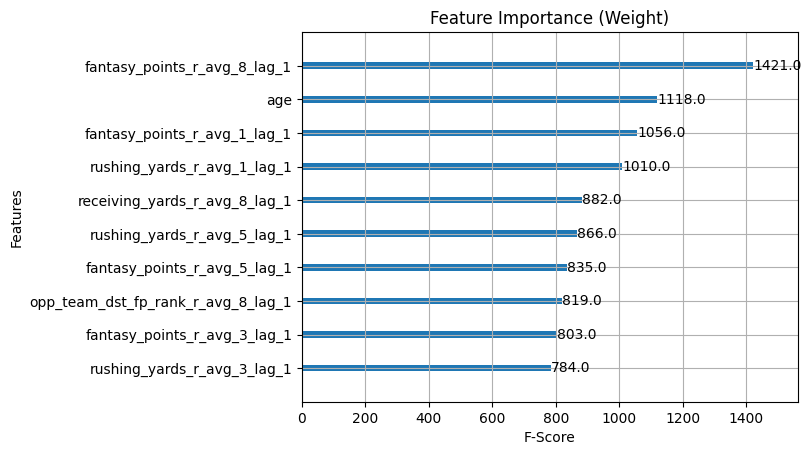

<Figure size 1000x800 with 0 Axes>

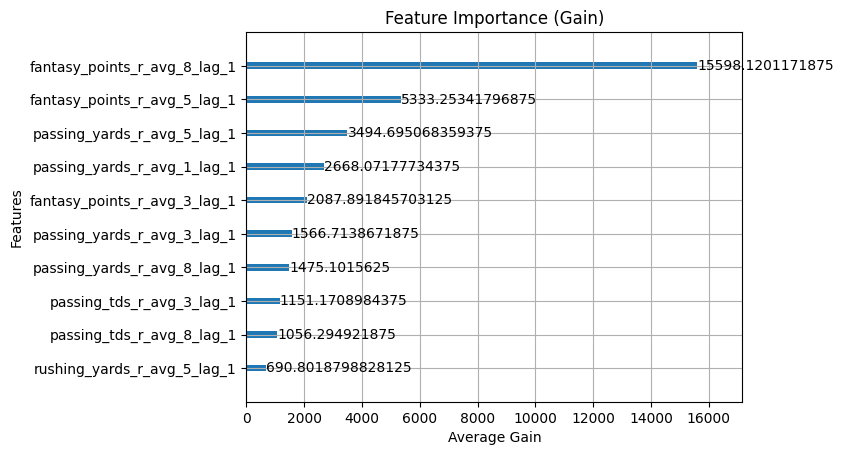

In [12]:
# Use the trained model to plot feature importance
import matplotlib.pyplot as plt
import xgboost as xgb

def plot_feature_importance(model, feature_names):
    feature_names = feature_names.tolist() if isinstance(feature_names, pd.Index) else feature_names
    model.get_booster().feature_names = feature_names
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(model, importance_type='weight', max_num_features=10, xlabel='F-Score', )
    plt.title("Feature Importance (Weight)")
    plt.show()
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(model, importance_type='gain', max_num_features=10, xlabel='Average Gain')
    plt.title("Feature Importance (Gain)")
    plt.show()

# Use the correct feature names for the model - remove 'Fantasy_points' from the list
plot_feature_importance(model, X_train.columns)

In [45]:
# Plot Correlation Heatmap
# import seaborn as sns

# def plot_correlation_heatmap(model, feature_names):
#     feature_names = feature_names.tolist() if isinstance(feature_names, pd.Index) else feature_names
#     model.get_booster().feature_names = feature_names
#     # Create a DataFrame from the feature names
#     X = final_df_with_lags[feature_names].copy()
#     y = final_df_with_lags['fantasy_points'].copy()
    
    
#     # scaler = MinMaxScaler()
#     # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#     plt.figure(figsize=(12, 10))
#     corr = X.corr()
#     sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
#     plt.title("Feature Correlation Heatmap")
#     plt.show()

# X = final_df_with_lags.iloc[:, 11:-1]  # Features (all columns except first 11 and last column)
# # X = X.drop(columns=['fantasy_points'])  # Drop target variable
# plot_correlation_heatmap(X)

Learning Rate: 0.01, MAE: 4.162261096363354
Learning Rate: 0.02, MAE: 3.879302779403554
Learning Rate: 0.03, MAE: 3.802306526571324
Learning Rate: 0.04, MAE: 3.781911786142448
Learning Rate: 0.05, MAE: 3.7773316175859626
Learning Rate: 0.06, MAE: 3.7783995793806877
Learning Rate: 0.07, MAE: 3.7723673825771207
Learning Rate: 0.08, MAE: 3.7755478709322645
Learning Rate: 0.09, MAE: 3.769478253646175
Learning Rate: 0.1, MAE: 3.775765186352011


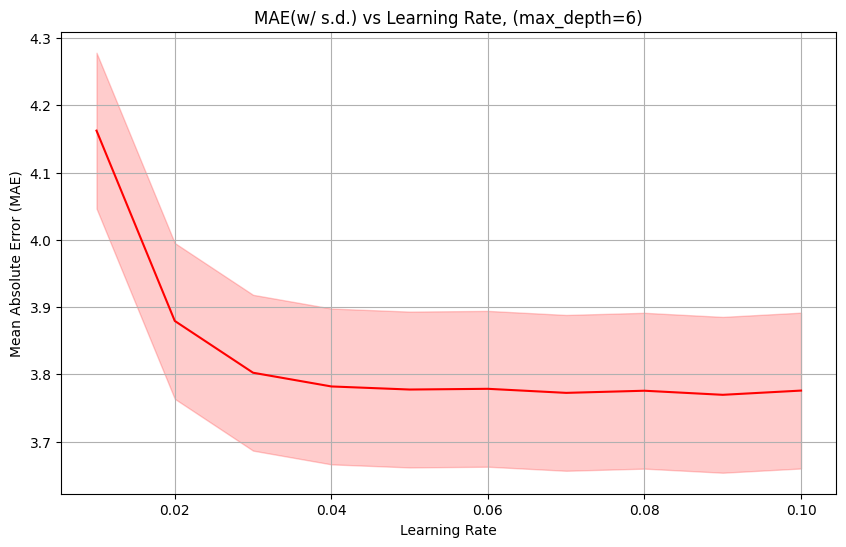

In [46]:
# Use the trained model to plot MAE against various learning rates with area of std deviation as shaded region
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
def plot_mae_vs_learning_rate(X_train, y_train, X_test, y_test, learning_rates):
    mae_values = []
    for lr in learning_rates:
        model = XGBRegressor(learning_rate=lr)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mae_values.append(mae)
        mae_values_std = np.std(mae_values)
        print(f"Learning Rate: {lr}, MAE: {mae}")

    plt.figure(figsize=(10, 6))
    plt.fill_between(learning_rates, np.array(mae_values) - mae_values_std, np.array(mae_values) + mae_values_std, alpha=0.2, color='r')
    plt.plot(learning_rates, mae_values, color='r')
    plt.xlabel('Learning Rate')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE(w/ s.d.) vs Learning Rate, (max_depth=6)')
    plt.grid(True)
    plt.show()
    
plot_mae_vs_learning_rate(X_train, y_train, X_test, y_test, learning_rates)

Max Depth: 3, MAE: 4.221033607817826
Max Depth: 4, MAE: 4.191186800750005
Max Depth: 5, MAE: 4.171855647363118
Max Depth: 6, MAE: 4.162261096363354
Max Depth: 7, MAE: 4.154741597224483
Max Depth: 8, MAE: 4.151886511258845
Max Depth: 9, MAE: 4.150293828382628
Max Depth: 10, MAE: 4.152842632026362


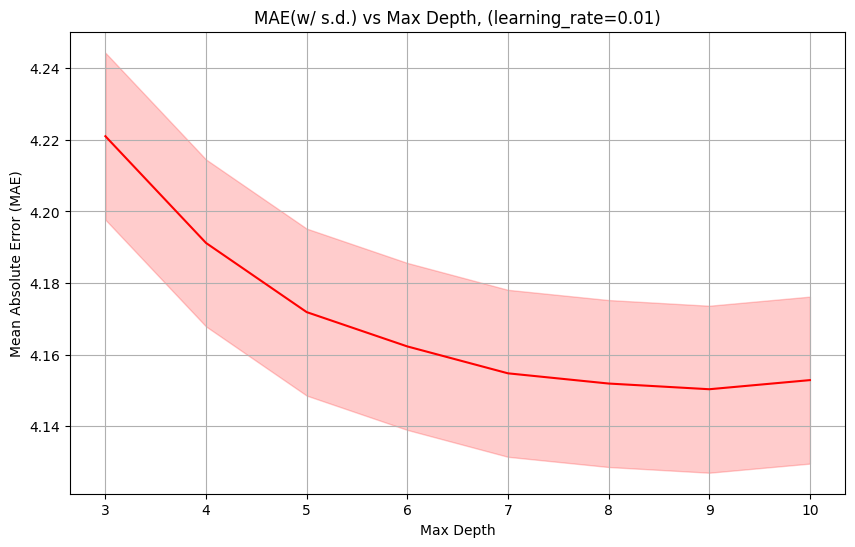

In [47]:
# Use the trained model to plot MAE against various max_depth with area of std deviation as shaded region
max_depths = [3, 4, 5, 6, 7, 8, 9, 10]
def plot_mae_vs_max_depth(X_train, y_train, X_test, y_test, max_depths):
    mae_values = []
    for md in max_depths:
        model = XGBRegressor(max_depth=md, learning_rate=0.01)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mae_values.append(mae)
        mae_values_std = np.std(mae_values)
        print(f"Max Depth: {md}, MAE: {mae}")

    plt.figure(figsize=(10, 6))
    plt.fill_between(max_depths, np.array(mae_values) - mae_values_std, np.array(mae_values) + mae_values_std, alpha=0.2, color='r')
    plt.plot(max_depths, mae_values, color='r')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE(w/ s.d.) vs Max Depth, (learning_rate=0.01)')
    plt.grid(True)
    plt.show()

plot_mae_vs_max_depth(X_train, y_train, X_test, y_test, max_depths)

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 12137/12193 [02:55<00:00]        

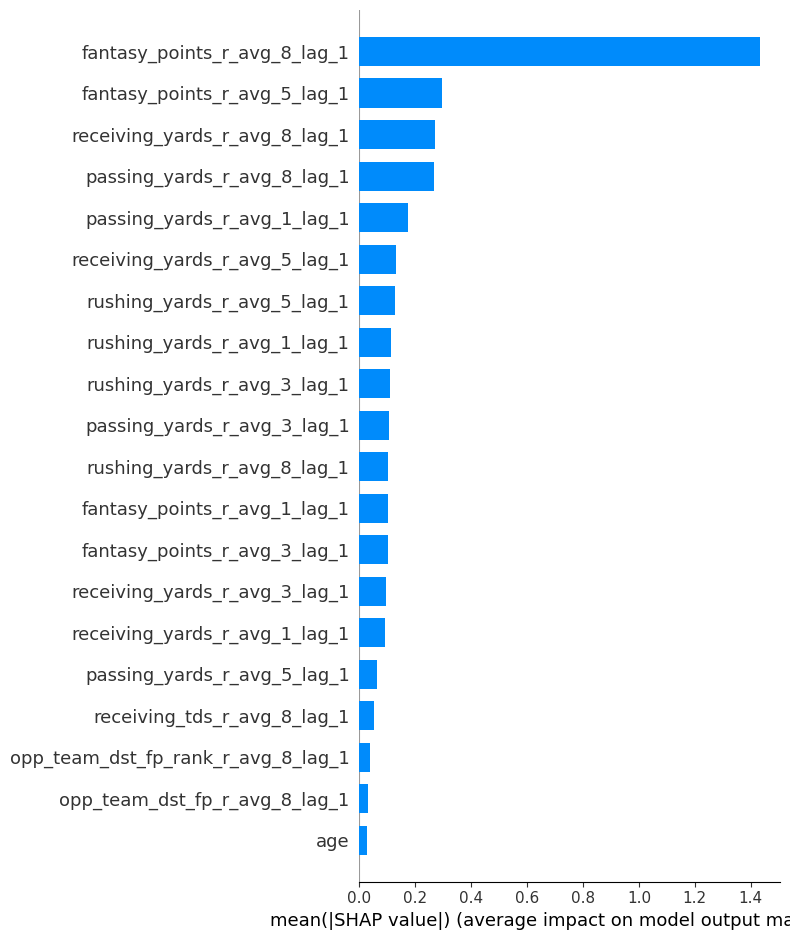

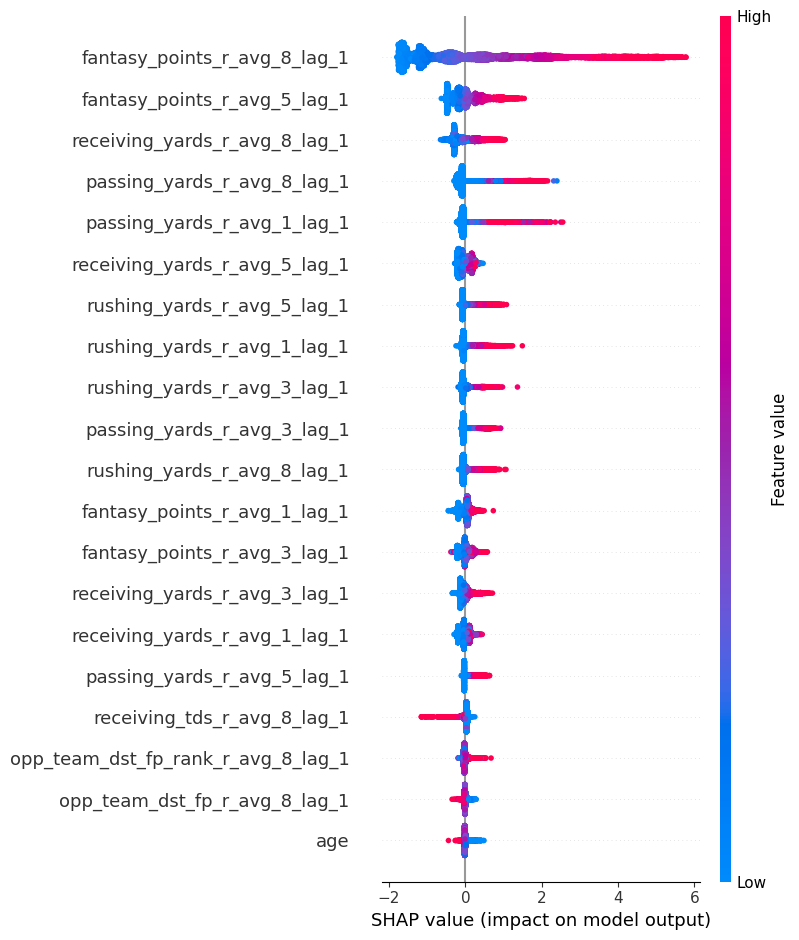

In [13]:
# Plot feature importance using SHAP values
import shap

def plot_shap_feature_importance(model, X_test):
    # Create a SHAP explainer
    explainer = shap.Explainer(model, X_test)
    
    # Calculate SHAP values
    shap_values = explainer(X_test)
    
    # Summary plot (bar and beeswarm)
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    shap.summary_plot(shap_values, X_test)

plot_shap_feature_importance(model, X_test)

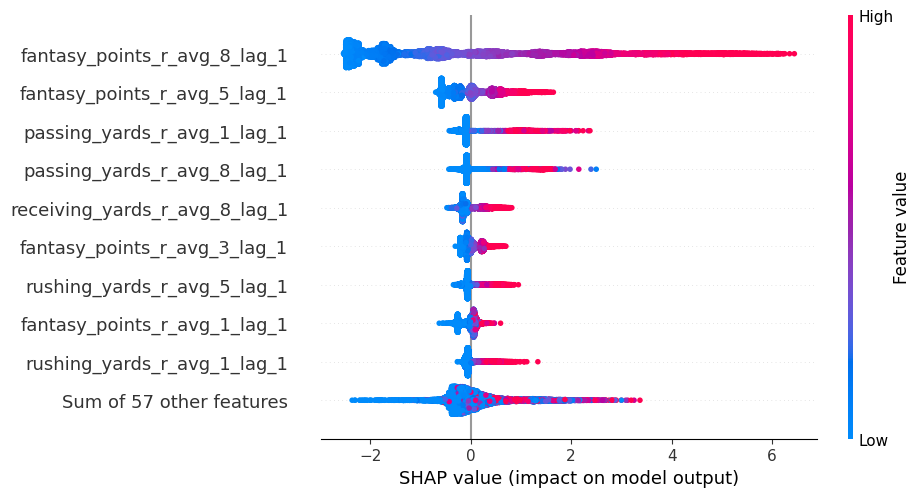

In [14]:
# Function to use SHAP to explain the machine learning model behavior with SHAP beeswarm plot
import shap

def plot_shap_beeswarm(X_test, model):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    plt.figure(figsize=(10, 6))
    shap.plots.beeswarm(shap_values)

plot_shap_beeswarm(X_test, model)

In [15]:
# Function to use model to predict fantasy points for all weeks in final_df_with_lags, keeping 'player_id' for mapping back to player names later
def predict_fantasy_points(model, final_df_with_lags):
    """
    Predict fantasy points for each player's next game using the trained model.
    
    Args:
        model: Trained XGBoost model
        final_df_with_lags: DataFrame containing player stats with lagged features
        
    Returns:
        numpy.array: Predicted fantasy points for each player
    """
    final_df_with_lags = final_df_with_lags.copy()
    
    # Get features for prediction (exclude first 11 columns and target variable)
    X_ = final_df_with_lags.iloc[:, 11:].drop(columns=['fantasy_points'])
    
    # Scale features using MinMaxScaler fit only on prediction data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_)
    X_latest_scaled = X_scaled
    
    # Make predictions
    predicted_fantasy_points = model.predict(X_latest_scaled)
    
    final_df_with_lags['predicted_fantasy_points'] = predicted_fantasy_points

    return final_df_with_lags[['player_id', 'player_name', 'position_group', 'team', 'season', 'week', 'fantasy_points', 'predicted_fantasy_points']]

# Predict fantasy points for next week using the last trained model
predicted_fantasy_points = predict_fantasy_points(model, final_df_with_lags)
predicted_fantasy_points

,player_id,player_name,position_group,team,season,week,fantasy_points,predicted_fantasy_points
0,00-0007091,M.Hasselbeck,QB,IND,2014,4,-0.20,4.138823
1,00-0007091,M.Hasselbeck,QB,IND,2014,16,7.04,3.725093
2,00-0007091,M.Hasselbeck,QB,IND,2014,17,9.40,5.396152
3,00-0007091,M.Hasselbeck,QB,IND,2015,4,15.38,7.706390
4,00-0007091,M.Hasselbeck,QB,IND,2015,5,16.22,15.060385
...,...,...,...,...,...,...,...,...
60964,00-0039921,T.Benson,RB,ARI,2024,10,8.70,5.273101
60965,00-0039921,T.Benson,RB,ARI,2024,12,1.80,6.486992
60966,00-0039921,T.Benson,RB,ARI,2024,13,2.00,5.522750
60967,00-0039921,T.Benson,RB,ARI,2024,14,1.90,5.176586


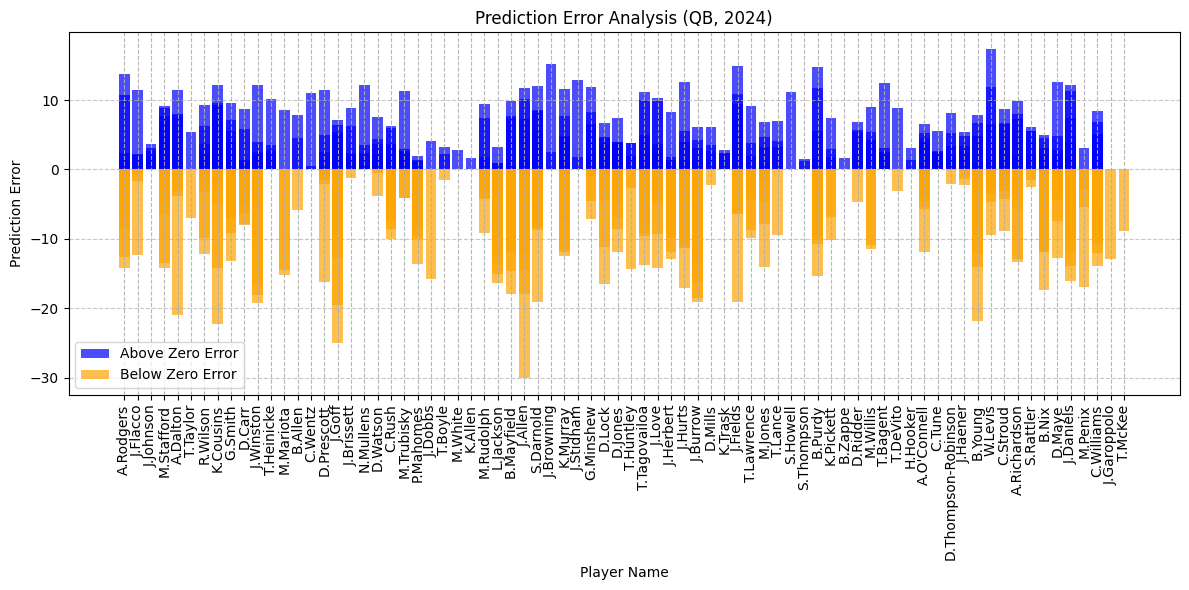

In [16]:
# Function for Prediction error analysis
def analyze_prediction_errors(predicted_fantasy_points):
    predicted_fantasy_points = predicted_fantasy_points.copy()
    # 2024 season only
    predicted_fantasy_points = predicted_fantasy_points[predicted_fantasy_points['season'] == 2024]
    # All QB position_group only
    predicted_fantasy_points = predicted_fantasy_points[predicted_fantasy_points['position_group'] == 'QB']
    predicted_fantasy_points['prediction_error'] = predicted_fantasy_points['predicted_fantasy_points'] - predicted_fantasy_points['fantasy_points']

    # Convert prediction_error to percent_error - not absolute
    predicted_fantasy_points['percent_error'] = (predicted_fantasy_points['prediction_error'] / predicted_fantasy_points['fantasy_points'])

    # Above and below zero errors
    above_zero = predicted_fantasy_points[predicted_fantasy_points['prediction_error'] >= 0]
    below_zero = predicted_fantasy_points[predicted_fantasy_points['prediction_error'] < 0]

    plt.figure(figsize=(12, 6))

    # Plot above 0 error chart with blue color and alpha 0.7
    plt.bar(above_zero['player_name'], above_zero['prediction_error'], color='blue', alpha=0.7, label='Above Zero Error')
    # Plot below 0 error chart with orange color and alpha 0.7
    plt.bar(below_zero['player_name'], below_zero['prediction_error'], color='orange', alpha=0.7, label='Below Zero Error')
    # All vertical grid lines throughout the plot
    plt.grid(axis='x', linestyle='--', alpha=0.9)
    # All horizontal grid lines throughout the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xlabel('Player Name')
    plt.ylabel('Prediction Error')
    plt.title('Prediction Error Analysis (QB, 2024)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_prediction_errors(predicted_fantasy_points)


## 2025 Predictions

In [52]:
# Load player game-level stats for 2025 season to identify current rosters
# player_stats_2025 = nfl.load_player_stats(2025)
# player_stats_pandas_2025 = player_stats_2025.to_pandas()
# player_stats_pandas_2025 = player_stats_pandas_2025[player_stats_pandas_2025['season_type'] != 'POST']
# player_stats_pandas_2025

In [53]:
# Create Complete Team Defense Dataframes
# def create_team_defense_df(complete_data_df):
#     # Filter for defensive positions
#     defensive_positions = ['DL', 'LB', 'DB']
#     team_defense_df = complete_data_df[complete_data_df['pos_abb'].isin(defensive_positions)].copy()
    
#     return team_defense_df

# team_defense_df = create_team_defense_df(complete_data_df)
# team_defense_df.columns